In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Crop_Prediction_Dataset_ENHANCED.csv")


In [3]:
df.head()

,Avg_Temp_c,Soil_Moisture_pct,Soil_pH,Fertilizer_kg_per_hectare,Soil_Quality_Index,Season,Rainfall_mm,Crop_Type,Crop_Yield_ton_per_ha
0,28.93,31.2,5.98,60.7,3.72,Rainy,205.7,Maize,4.361
1,20.72,29.7,8.41,120.2,4.77,Rainy,255.1,Rice,3.262
2,19.54,11.8,7.33,169.0,4.66,Winter,250.6,Wheat,3.798
3,26.03,54.2,5.99,95.8,6.05,Summer,122.9,Rice,4.271
4,29.39,43.8,7.91,243.9,2.44,Rainy,69.2,Maize,4.255


In [4]:
df.isnull().sum()

Avg_Temp_c                   0
Soil_Moisture_pct            0
Soil_pH                      0
Fertilizer_kg_per_hectare    0
Soil_Quality_Index           0
Season                       0
Rainfall_mm                  0
Crop_Type                    0
Crop_Yield_ton_per_ha        0
dtype: int64

In [5]:
df['Season'] = df['Season'].fillna('Unknown')
df['Crop_Type'] = df['Crop_Type'].fillna('Unknown')


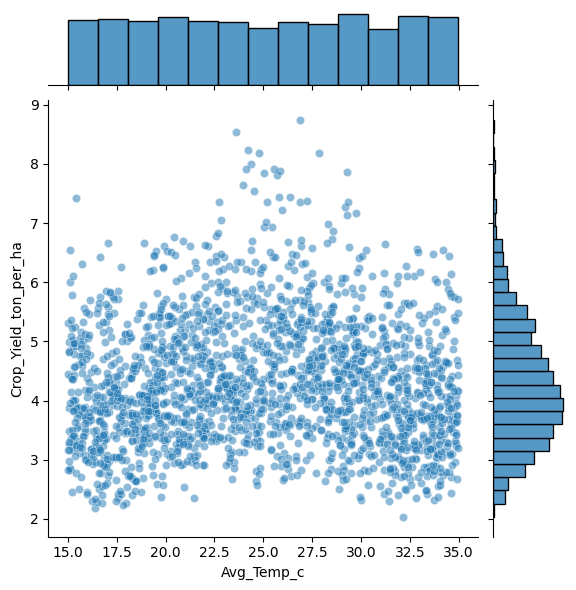

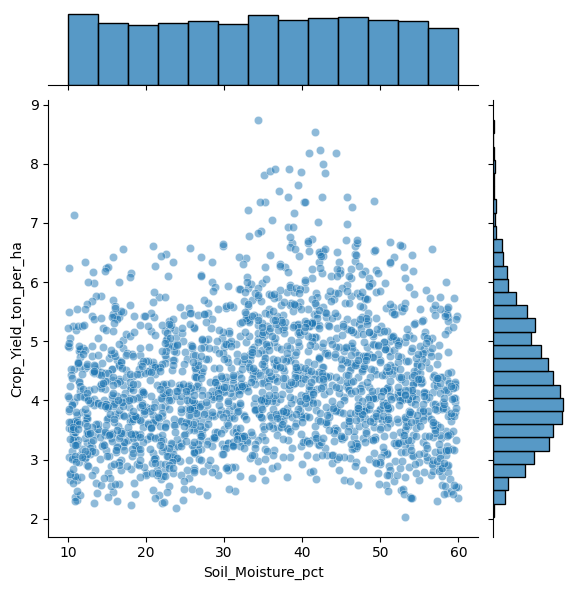

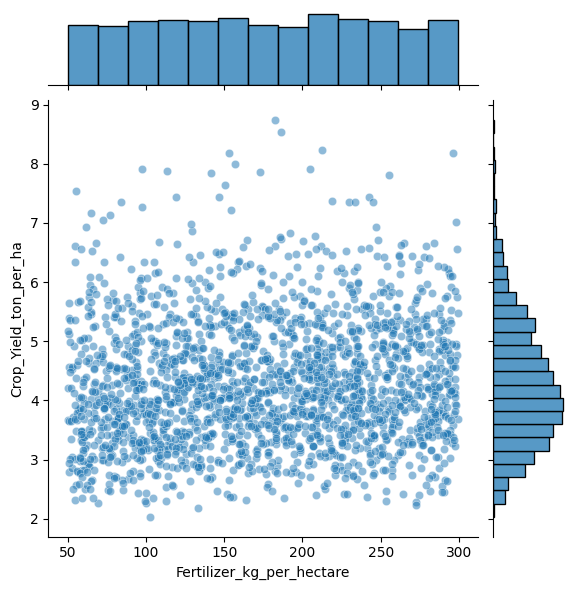

In [6]:
sns.jointplot(x="Avg_Temp_c", y="Crop_Yield_ton_per_ha", data=df, kind="scatter", alpha=0.5)
plt.show()

sns.jointplot(x="Soil_Moisture_pct", y="Crop_Yield_ton_per_ha", data=df, kind="scatter", alpha=0.5)
plt.show()

sns.jointplot(x="Fertilizer_kg_per_hectare", y="Crop_Yield_ton_per_ha", data=df, kind="scatter", alpha=0.5)
plt.show()


In [7]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [8]:
print(x.columns.tolist())


['Avg_Temp_c', 'Soil_Moisture_pct', 'Soil_pH', 'Fertilizer_kg_per_hectare', 'Soil_Quality_Index', 'Season', 'Rainfall_mm', 'Crop_Type']


In [9]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}

for col in ['Season', 'Crop_Type']:
    le = LabelEncoder()
    x[col] = le.fit_transform(x[col])
    label_encoders[col] = le


In [10]:
le = label_encoders['Season']
for i, class_name in enumerate(le.classes_):
    print(f"{class_name} -> {i}")


Rainy -> 0
Summer -> 1
Winter -> 2


In [11]:
le = label_encoders['Crop_Type']
for i, class_name in enumerate(le.classes_):
    print(f"{class_name} -> {i}")


Corn -> 0
Maize -> 1
Rice -> 2
Wheat -> 3


In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42,test_size=0.3)

In [13]:
from sklearn.ensemble import RandomForestRegressor
X = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
X.fit(x_train,y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


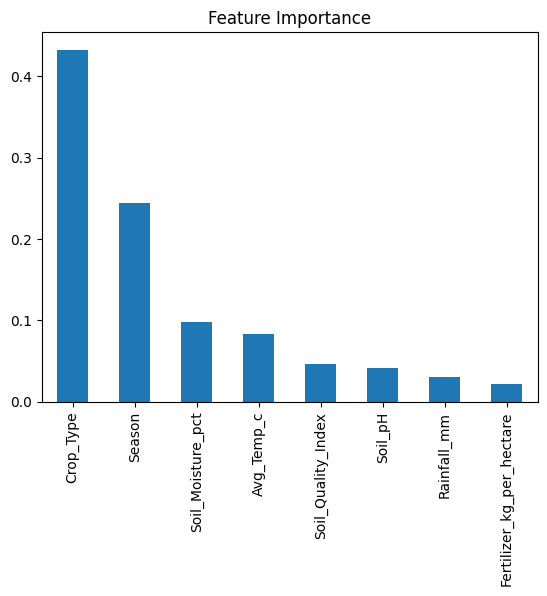

In [14]:

feature_importance = pd.Series(
    X.feature_importances_, index=x.columns
).sort_values(ascending=False)

feature_importance.plot(kind="bar")
plt.title("Feature Importance")
plt.show()


## Feature Importance Analysis

The Random Forest model indicates that Crop_Type and Season are the most influential features in predicting crop yield.
This suggests that yield patterns vary significantly across different crops and growing seasons.

Environmental factors such as soil moisture, temperature, and soil quality also contribute to yield prediction,
while fertilizer usage and rainfall show comparatively lower importance in this dataset.

In [15]:
from sklearn.metrics import r2_score

y_pred = X.predict(x_test)
accuracy = r2_score(y_test, y_pred)

print("Model Accuracy (R² Score):", accuracy)


Model Accuracy (R² Score): 0.8461119496542043


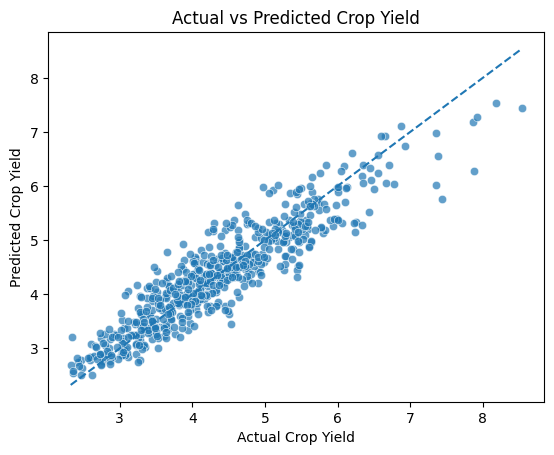

In [16]:
plt.figure()
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--"
)
plt.xlabel("Actual Crop Yield")
plt.ylabel("Predicted Crop Yield")
plt.title("Actual vs Predicted Crop Yield")
plt.show()


In [17]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(X, x, y, cv=5, scoring='r2')
print("CV R² mean:", scores.mean())
print("CV R² std:", scores.std())


CV R² mean: 0.8406911315970396
CV R² std: 0.016368126337538827


In [18]:
def safe_transform(le, value):
    while value not in le.classes_:
        print("Invalid option. Please choose from:", list(le.classes_))
        value = input("Enter again: ")
    return le.transform([value])[0]


User Input

In [19]:
def get_user_input():
    print("\nEnter crop details for yield prediction:")

    avg_temp = float(input("Avg Temp (°C): "))
    soil_moisture = float(input("Soil Moisture (%): "))
    soil_ph = float(input("Soil pH: "))
    fertilizer = float(input("Fertilizer (kg/ha): "))
    soil_quality = float(input("Soil Quality Index: "))
    
    print("Valid Seasons:", list(label_encoders['Season'].classes_))
    season = input("Season: ")
    season_encoded = safe_transform(label_encoders['Season'], season)
    
    rainfall = float(input("Rainfall (mm): "))
    
    print("Valid Crop Types:", list(label_encoders['Crop_Type'].classes_))
    crop_type = input("Crop Type: ")
    crop_encoded = safe_transform(label_encoders['Crop_Type'], crop_type)
    
    user_df = pd.DataFrame([[avg_temp, soil_moisture, soil_ph, fertilizer, soil_quality, season_encoded, rainfall, crop_encoded]],
                           columns=['Avg_Temp_c', 'Soil_Moisture_pct', 'Soil_pH', 
                                    'Fertilizer_kg_per_hectare', 'Soil_Quality_Index', 
                                    'Season', 'Rainfall_mm', 'Crop_Type'])
    return user_df

while True:
    user_input = get_user_input()
    predicted_yield = X.predict(user_input)
    print(f"\n✅ Predicted Crop Yield: {predicted_yield[0]:.2f} ton/ha\n")

    cont = input("Do you want to predict another crop yield? (yes/no): ").strip().lower()
    if cont != 'yes':
        print("Thank you for using the Crop Yield Predictor!")
        break


Enter crop details for yield prediction:
Valid Seasons: ['Rainy', 'Summer', 'Winter']
Valid Crop Types: ['Corn', 'Maize', 'Rice', 'Wheat']

✅ Predicted Crop Yield: 3.65 ton/ha

Thank you for using the Crop Yield Predictor!
